In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [97]:
## load data for the roi of interest    
# roi_of_interest = 'roi_1'
# roi_of_interest = 'roi_1'
# roi_of_interest  = 'roi_3'
# roi_of_interest = 'roi_2'
roi_of_interest = 'run2_roi_2'
# roi_of_interest = 'run2_roi_3'

# load the sg_object
with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [98]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [99]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['object_id'] = sg_obj.gdf.index
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf.index.name = 'index'
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [100]:
merged_gdf = sg_obj.gdf

In [101]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])

obs_cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes'] + cols_to_keep 

adata_genes.obs = df[obs_cols]

adata_genes.obs.index = [str(x) for x in adata_genes.obs.index]

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_63737/749676134.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[gene_cols])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [102]:
adata_genes.obs.groupby('bc_cluster').size() > 10

bc_cluster
0.0       False
1.0       False
2.0       False
3.0       False
4.0       False
          ...  
3557.0    False
3558.0    False
3559.0    False
3560.0    False
3561.0    False
Length: 3562, dtype: bool

Metrics based on filtering by 3 barcodes per cluster
Average cells per cluster 11.593421052631578
Number of clusters 1520
Metrics based on additionally filtering by 10 cells per cluster
Average cells per cluster 88.96951219512195
Number of clusters 164


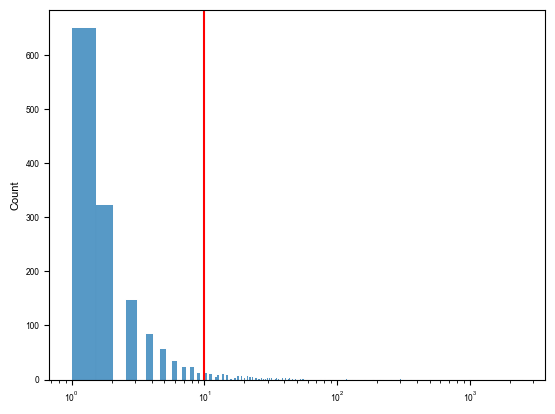

In [103]:
### FILTERING CLONES DOWN TO THOSE WITH MANY BARCODES AND/OR MANY CELLS

n_bcs_per_cluster_cutoff = 3
n_cells_per_cluster_cutoff = 10


## first get a GDF that's just those with at least 10 cells
cluster_sizes = adata_genes.obs.groupby('bc_cluster').size()
large_clusters = cluster_sizes[cluster_sizes >= 10].index.tolist()

large_clusters_gdf = large_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(large_clusters)]

## now, let's look at onces with at least 10 cells and 3 barcodes per clone.
confident_clusters = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)

print(f'Metrics based on filtering by {n_bcs_per_cluster_cutoff} barcodes per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Number of clusters',len(cluster_names))

sns.histplot(cluster_sizes)
plt.axvline(n_cells_per_cluster_cutoff,color='r')
plt.xscale('log')

# large enough clusters
large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

confident_clusters = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
# sns.histplot(cluster_sizes)

print(f'Metrics based on additionally filtering by {n_cells_per_cluster_cutoff} cells per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Number of clusters',len(cluster_names))

confident_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(confident_clusters.obs['bc_cluster'].values)]






In [104]:
np.unique(confident_clusters.obs['bc_cluster'].values)

array([   7.,   15.,   16.,   21.,   33.,   35.,   38.,   42.,   45.,
         46.,   51.,   63.,   65.,   75.,   80.,   86.,   90.,   99.,
        100.,  102.,  115.,  120.,  123.,  124.,  125.,  126.,  127.,
        133.,  135.,  144.,  145.,  154.,  163.,  172.,  179.,  188.,
        194.,  200.,  209.,  211.,  213.,  218.,  220.,  231.,  233.,
        234.,  236.,  237.,  239.,  243.,  244.,  250.,  252.,  271.,
        277.,  288.,  303.,  304.,  317.,  321.,  323.,  333.,  343.,
        354.,  356.,  367.,  374.,  393.,  400.,  401.,  404.,  407.,
        410.,  413.,  418.,  426.,  431.,  432.,  434.,  440.,  445.,
        446.,  447.,  456.,  460.,  473.,  491.,  502.,  517.,  524.,
        525.,  526.,  546.,  576.,  591.,  592.,  603.,  635.,  658.,
        679.,  720.,  724.,  739.,  740.,  758.,  766.,  767.,  769.,
        779.,  787.,  797.,  803.,  810.,  825.,  838.,  848.,  853.,
        855.,  863.,  865.,  867.,  876.,  904.,  991., 1053., 1081.,
       1092., 1129.,

In [105]:
sg_obj.gdf

nucleus  \
0      POLYGON ((20452.000 978.000, 20472.000 980.000...   
1      POLYGON ((20899.000 1116.000, 20919.000 1120.0...   
2      POLYGON ((23405.000 1289.000, 23422.000 1289.0...   
3      POLYGON ((22362.000 2604.000, 22371.000 2604.0...   
4      POLYGON ((34450.000 9802.000, 34456.000 9802.0...   
...                                                  ...   
79141  POLYGON ((21998.000 9799.000, 22000.000 9799.0...   
79142  POLYGON ((17051.000 9800.000, 17090.000 9803.0...   
79143  POLYGON ((25990.000 9800.000, 26006.000 9801.0...   
79144  POLYGON ((29231.000 9800.000, 29239.000 9800.0...   
79145  POLYGON ((13872.000 9801.000, 13898.000 9858.0...   

                                         nucleus_dilated  \
0      POLYGON ((20366.000 1040.661, 20365.685 1041.3...   
1      POLYGON ((20893.700 1107.520, 20885.700 1112.5...   
2      POLYGON ((23401.154 1279.769, 23389.154 1284.7...   
3      POLYGON ((22354.191 2597.753, 22350.191 2602.7...   
4      POLYGON ((34410.776 9860.918, 34421.929 9872.0...   
...                                                  ...   
79141  POLYGON ((21994.227 9789.739, 21968.317 9800.2...   
79142  POLYGON ((17048.710 9790.266, 17031.710 9794.2...   
79143  POLYGON ((25985.528 9791.056, 25975.528 9796.0...   
79144  POLYGON ((29224.753 9792.191, 29214.753 9800.1...   
79145  POLYGON ((13869.341 9791.360, 13840.341 9799.3...   

                 nucleus_centroid      center_x     center_y          area  \
0      POINT (20442.252 1036.183)  20442.252084  1036.182508  14465.012042   
1      POINT (20934.446 1155.448)  20934.446389  1155.447838   8310.292671   
2      POINT (23427.302 1328.096)  23427.302149  1328.095541   8030.740341   
3      POINT (22391.950 2660.513)  22391.949684  2660.512711   7791.201110   
4      POINT (34434.629 9833.058)  34434.628857  9833.058403   4928.902676   
...                           ...           ...          ...           ...   
79141  POINT (21987.939 9828.897)  21987.939394  9828.897300   5500.544273   
79142  POINT (17057.349 9832.790)  17057.348683  9832.790086   7029.281662   
79143  POINT (26005.495 9880.858)  26005.494746  9880.858088  20049.671924   
79144  POINT (29248.028 9850.902)  29248.027506  9850.902230   5990.908719   
79145  POINT (13862.484 9865.244)  13862.483910  9865.244236  12053.901189   

      object_id cell_id  AKT1  AXL  ...  bc_093  bc_094  bc_095  bc_096  \
0             1       1   1.0  0.0  ...     0.0     0.0     1.0     0.0   
1            10      10   2.0  0.0  ...     0.0     0.0     0.0     0.0   
2           100     100   5.0  0.0  ...     0.0     0.0     0.0     0.0   
3          1000    1000   1.0  0.0  ...     0.0     0.0     0.0     0.0   
4         10000   10000   1.0  0.0  ...     0.0     0.0     0.0     0.0   
...         ...     ...   ...  ...  ...     ...     ...     ...     ...   
79141      9995    9995   0.0  0.0  ...     0.0     0.0     0.0     0.0   
79142      9996    9996   1.0  0.0  ...     0.0     0.0     0.0     0.0   
79143      9997    9997   4.0  0.0  ...     0.0     0.0     0.0     0.0   
79144      9998    9998   3.0  0.0  ...     0.0     0.0     0.0     0.0   
79145      9999    9999   4.0  0.0  ...     0.0     0.0     0.0     0.0   

       bc_cluster   bc_cluster_bc_names            bc_cluster_found_bcs  \
0           705.0                bc_074                      ['bc_074']   
1             NaN                   NaN                             NaN   
2             NaN                   NaN                             NaN   
3             NaN                   NaN                             NaN   
4             NaN                   NaN                             NaN   
...           ...                   ...                             ...   
79141       410.0  bc_001-bc_031-bc_087  ['bc_001', 'bc_031', 'bc_087']   
79142         NaN                   NaN                             NaN   
79143        90.0  bc_060-bc_077-bc_092  ['bc_060', 'bc_077', 'bc_092']   
79144         NaN  

In [106]:
### We can look at which clusters have the highest SFRP1 expression. Cluster 31 has the hightest.

# confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].median().sort_values(ascending=False).head(10)
# print('SFRP1 in confident clusters (>=3 barcodes, >=10 cells)')
# print('Fraction of cells with SFRP1 > 1')
# print(confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].apply(lambda x: (x > 1).sum() / len(x)).sort_values(ascending=False).head(10))
# print('Mean SFRP1 expression')
# print(confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10))

print('ALL CLONES ')

# print('Fraction of cells with SFRP1 > 1')
# print(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].apply(lambda x: (x > 1).sum() / len(x)).sort_values(ascending=False).head(10))
print('Mean SFRP1 expression')
print(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10))

# print number of objects in groupby


ALL CLONES 
Mean SFRP1 expression
bc_cluster
40.0      1.871383
1499.0    1.615385
862.0     1.545455
510.0     1.307692
473.0     1.300000
819.0     1.137931
87.0      1.101010
362.0     1.100000
100.0     1.043011
697.0     1.000000
Name: SFRP1, dtype: float64


In [107]:
large_clusters_gdf[large_clusters_gdf['bc_cluster'] == 40][['SFRP1','bc_cluster','bc_cluster_bc_names']]

SFRP1  bc_cluster bc_cluster_bc_names
28599    1.0        40.0              bc_073
28908    1.0        40.0              bc_073
30064    1.0        40.0              bc_073
30244    4.0        40.0              bc_073
31394    3.0        40.0              bc_073
...      ...         ...                 ...
73079    0.0        40.0              bc_073
73165    0.0        40.0              bc_073
73848    0.0        40.0              bc_073
74110    0.0        40.0              bc_073
74430    0.0        40.0              bc_073

[622 rows x 3 columns]

In [108]:
large_clusters_gdf[large_clusters_gdf['bc_cluster'] == 862][['SFRP1','bc_cluster','bc_cluster_bc_names']]

SFRP1  bc_cluster bc_cluster_bc_names
40927    2.0       862.0       bc_009-bc_073
41007    0.0       862.0       bc_009-bc_073
41761    0.0       862.0       bc_009-bc_073
42018    1.0       862.0       bc_009-bc_073
42028    3.0       862.0       bc_009-bc_073
42448    1.0       862.0       bc_009-bc_073
42514    3.0       862.0       bc_009-bc_073
43966    1.0       862.0       bc_009-bc_073
44317    3.0       862.0       bc_009-bc_073
44618    1.0       862.0       bc_009-bc_073
45343    2.0       862.0       bc_009-bc_073

In [109]:
confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

bc_cluster
473.0     1.300000
100.0     1.043011
303.0     0.916667
1523.0    0.733333
38.0      0.713235
188.0     0.679245
440.0     0.600000
102.0     0.571429
524.0     0.500000
2545.0    0.466667
Name: SFRP1, dtype: float64

In [110]:
confident_clusters_gdf[confident_clusters_gdf['bc_cluster'] == 490][['bc_cluster','called_barcodes','bc_cluster_bc_names','SFRP1']]

Empty DataFrame
Columns: [bc_cluster, called_barcodes, bc_cluster_bc_names, SFRP1]
Index: []

In [111]:
confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).index[:10]

Float64Index([473.0, 100.0, 303.0, 1523.0, 38.0, 188.0, 440.0, 102.0, 524.0,
              2545.0],
             dtype='float64', name='bc_cluster')

In [112]:
large_clusters_gdf

nucleus  \
5      POLYGON ((28031.000 9803.000, 28050.000 9805.0...   
8      POLYGON ((14474.000 9805.000, 14487.000 9806.0...   
12     POLYGON ((15047.000 9808.000, 15058.000 9809.0...   
16     POLYGON ((22496.000 9809.000, 22512.000 9811.0...   
18     POLYGON ((16221.000 9810.000, 16223.000 9810.0...   
...                                                  ...   
79137  POLYGON ((28457.000 9797.000, 28476.000 9801.0...   
79138  POLYGON ((30154.000 9797.000, 30162.000 9797.0...   
79139  POLYGON ((14348.000 9798.000, 14358.000 9798.0...   
79141  POLYGON ((21998.000 9799.000, 22000.000 9799.0...   
79143  POLYGON ((25990.000 9800.000, 26006.000 9801.0...   

                                         nucleus_dilated  \
5      POLYGON ((28027.543 9793.617, 28008.543 9800.6...   
8      POLYGON ((14472.211 9795.161, 14461.211 9797.1...   
12     POLYGON ((15042.039 9799.318, 15028.039 9807.3...   
16     POLYGON ((22494.678 9799.088, 22479.678 9801.0...   
18     POLYGON ((16219.413 9800.127, 16163.413 9809.1...   
...                                                  ...   
79137  POLYGON ((28453.410 9787.667, 28440.410 9792.6...   
79138  POLYGON ((30150.286 9787.715, 30145.286 9789.7...   
79139  POLYGON ((14342.453 9789.679, 14336.453 9793.6...   
79141  POLYGON ((21994.227 9789.739, 21968.317 9800.2...   
79143  POLYGON ((25985.528 9791.056, 25975.528 9796.0...   

                 nucleus_centroid      center_x     center_y          area  \
5      POINT (28020.232 9852.860)  28020.232143  9852.859850   9874.936404   
8      POINT (14478.508 9837.351)  14478.507783  9837.351210   5775.901172   
12     POINT (15032.343 9861.348)  15032.342549  9861.348369  11042.305239   
16     POINT (22470.349 9854.086)  22470.348715  9854.085858   9361.046917   
18     POINT (16192.156 9859.917)  16192.156094  9859.917073   9570.125847   
...                           ...           ...          ...           ...   
79137  POINT (28460.100 9841.331)  28460.100120  9841.331462   7647.843316   
79138  POINT (30186.536 9848.194)  30186.535538  9848.194332   8861.861233   
79139  POINT (14358.592 9823.954)  14358.592417  9823.953870   3410.609704   
79141  POINT (21987.939 9828.897)  21987.939394  9828.897300   5500.544273   
79143  POINT (26005.495 9880.858)  26005.494746  9880.858088  20049.671924   

      object_id cell_id  AKT1  AXL  ...  bc_093  bc_094  bc_095  bc_096  \
5         10001   10001   3.0  0.0  ...     0.0     0.0     0.0     0.0   
8         10004   10004   0.0  0.0  ...     0.0     0.0     0.0     0.0   
12        10008   10008   2.0  0.0  ...     0.0     0.0     0.0     0.0   
16        10011   10011   4.0  0.0  ...     0.0     0.0     0.0     0.0   
18        10013   10013   1.0  0.0  ...     0.0     0.0     0.0     0.0   
...         ...     ...   ...  ...  ...     ...     ...     ...     ...   
79137      9991    9991   3.0  0.0  ...     0.0     0.0     0.0     0.0   
79138      9992    9992   1.0  0.0  ...     0.0     0.0     0.0     0.0   
79139      9993    9993   1.0  1.0  ...     0.0     0.0     0.0     0.0   
79141      9995    9995   0.0  0.0  ...     0.0     0.0     0.0     0.0   
79143      9997    9997   4.0  0.0  ...     0.0     0.0     0.0     0.0   

       bc_cluster   bc_cluster_bc_names            bc_cluster_found_bcs  \
5          1068.0         bc_025-bc_092            ['bc_025', 'bc_092']   
8          1538.0         bc_033-bc_074            ['bc_033', 'bc_074']   
12          464.0                bc_033                      ['bc_033']   
16          672.0         bc_048-bc_060            ['bc_048', 'bc_060']   
18         1390.0                bc_002                      ['bc_002']   
...           ...                   ...                             ...   
79137       456.0  bc_056-bc_087-bc_092  ['bc_056', 'bc_087', 'bc_092']   
79138       312.0         bc_022-bc_074            ['bc_022', 'bc_074']   
79139       290.0         bc_044-bc_074            ['bc_044', 'bc_074']   
79141       410.0  

In [171]:
## SFRP1 clones of interest
clones_by_roi = {
    'roi_1':[812],
    'roi_2':[31],
    'roi_3':[],
    'run2_roi_2':[40,1262],
    'run2_roi_3':[],

}

### Define SFRP1 regions of interest

clone_lims = {
    # 'roi_1': [[3000, 7000, 33000, 40000]], # xmin, xmax, ymin, ymax
    # # 'roi_2': [1000, 2000, 1000, 2000],
    # 'roi_3': [[18000,25000,12000,19000],
              
    #           ],

    'run2_roi_2': {40:[6000, 15000, 20000, 31000],
                #    698:[18000, 23000, 48000, 57000],
                   205:[18000, 23000, 48000, 57000],
                   
                #    40:[8000, 18000, 20000, 30000],
                    # [18000, 23000, 48000, 57000],
                    # [44000, 46000, 41000, 53000],
                    # [8800, 13000, 25000, 53000],
                    # [1000, 2000, 1000, 2000],
    },
    # 'run2_roi_3': [[25000, 30000, 28000, 32000],
    #                 [27000, 32000, 10000, 15000],
    #                 # [44000, 46000, 41000, 53000],
    #                 # [1000, 2000, 1000, 2000],
    #                ],

}


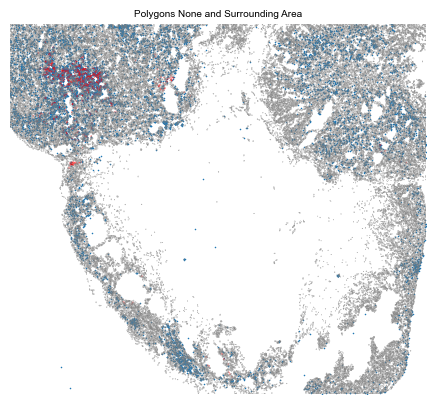

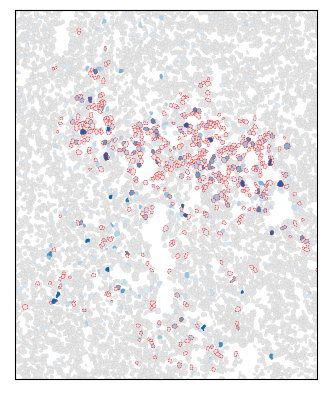

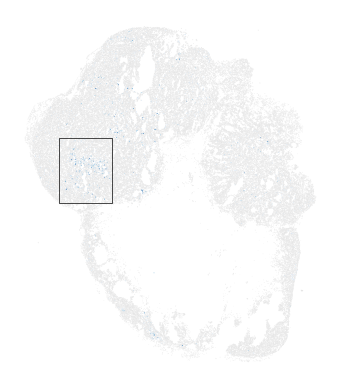

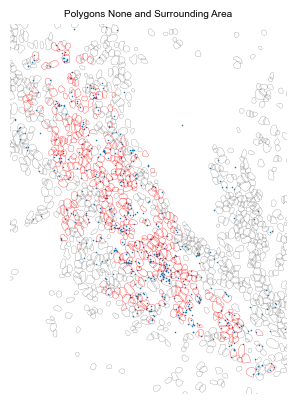

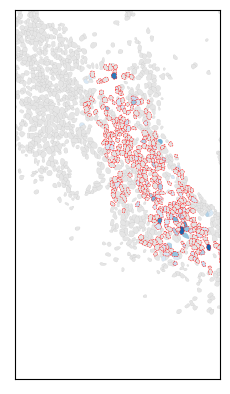

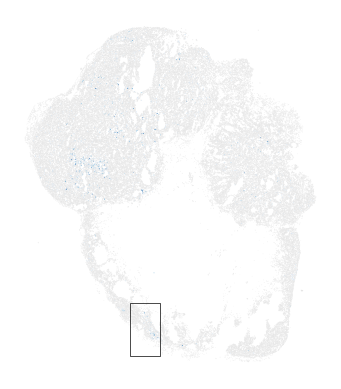

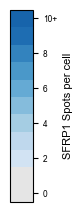

In [173]:
gene_of_interest = 'SFRP1'
# clusters_of_interest = confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)['bc_cluster']
# clusters_of_interest = confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).index[:10]
clusters_of_interest = large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).index[:5]

clusters_of_interest = [40,205]
# large_clusters_gdf[large_clusters_gdf['bc_cluster'] == 862][['SFRP1','bc_cluster','bc_cluster_bc_names']]

for cluster_of_interest in clusters_of_interest:

  # get the cells associated with the manual cluster
  # cluster_cells = list(confident_clusters.obs[confident_clusters.obs['bc_cluster'].isin([cluster_of_interest])]['object_id'].values)
  cluster_cells = list(large_clusters_gdf[large_clusters_gdf['bc_cluster'].isin([cluster_of_interest])]['cell_id'].values)
  # cluster_cells = [int(x) for x in cluster_cells]
  central_ix = int(len(cluster_cells)/2) 
  cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

  # region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=1,id_field='cell_id')

  fig,ax = plt.subplots()
  tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                              color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                                #  id_field='object_id',
                                # id_field='cell_id',
                              annotate=False,image_scale=0.1,
                              focal_outline_color='r',other_outline_color='gray',
                              interior_marker='.',single_mode=False,lw=0.2,
                              exterior_marker='.',marker_size=5,ax=ax)


  # ymin,ymax = plt.ylim()
  # xmin,xmax = plt.xlim()

  xmin,xmax,ymin,ymax = clone_lims[roi_of_interest][cluster_of_interest]

  plt.axis('off')
  # plt.title()
  plt.gca().invert_yaxis()

  ### PLOT THE ZOOMED IN IMAGE     
  fig,ax = plt.subplots()

  vmin = 2
  vmax = 10

  norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

  bbox = box(xmin,ymin,xmax,ymax)
  other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

  merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

  cmap = matplotlib.cm.get_cmap('Blues').copy()
  cmap = cmap(np.linspace(0.15, 0.8, 256))

  cmap = matplotlib.colors.ListedColormap(cmap)
  cmap.set_under('#e5e5e5') # set low values to gray

  merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                  vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

  this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
  # this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

  merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

  # print(merged_gdf_focal.shape)
  merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                  vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.35,linestyle='--')
    # merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
    #               vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

  # Add the patch to the Axes
  plt.xlim(xmin,xmax)
  plt.ylim(ymin,ymax)
  plt.gca().invert_yaxis()

  ax.set_xticks([])
  ax.set_yticks([])
  # ax.set_facecolor('#F5F5F5')
  plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_zoom_grayed.pdf',bbox_inches='tight')


  ### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
  fig,ax = plt.subplots()

  merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                  edgecolor='#d9d9d9',linewidth=0.0)

  # rectangle where magnification is
  rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)

  ax.set_facecolor('#F5F5F5')
  plt.axis('off')
  plt.gca().invert_yaxis()

  # plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_full_grayed.pdf',bbox_inches='tight',transparent=True)
  plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_full_grayed.png',dpi=500,bbox_inches='tight',transparent=True)



### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(0.3,2.5))
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])

plt.savefig(f'../graphs/other_rois/{roi_of_interest}/SFRP1_colorbar_grayed.pdf',bbox_inches='tight',transparent=True)



In [18]:
# extract the region close to cluster 100
cluster_of_interest = 100

cluster_cells = list(large_clusters_gdf[large_clusters_gdf['bc_cluster'].isin([cluster_of_interest])]['cell_id'].values)
# cluster_cells = [int(x) for x in cluster_cells]
central_ix = int(len(cluster_cells)/2) 
cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=10,id_field='cell_id')


In [19]:

## get xy bounds of the region

xmin = region['center_x'].min() - 1000
xmax = region['center_x'].max() + 1000
ymin = region['center_y'].min() - 1000
ymax = region['center_y'].max() + 1000

print(f'X bounds: {xmin} to {xmax}')
print(f'Y bounds: {ymin} to {ymax}')

# region

X bounds: 8842.07109620498 to 12530.372552280842
Y bounds: 24961.97813512099 to 28529.071622769752


In [20]:
# plot SFRP1 spots for the whole roi

# open spots file
spots_df = pd.read_csv(tools.roi_file_paths[roi_of_interest]["spots_file"])

<Figure size 640x480 with 0 Axes>

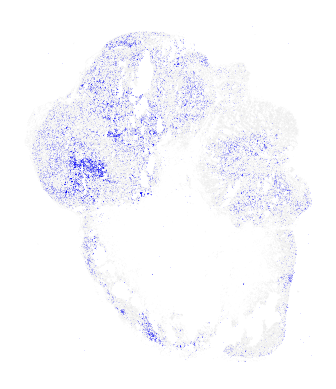

In [21]:
# plt.figure()
gene_of_interest = 'SFRP1'


plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)
spots_gene = spots_df[spots_df['name']==gene_of_interest]
plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0,color='b')

# plt.title(gene_of_interest)
plt.gca().invert_yaxis()

# plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_SFRP1_full.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_SFRP1_full_withaxis.png',dpi=500,bbox_inches='tight',transparent=True)
# plt.savefig(f'../graphs/space_VEGFA_MITF_full.png',dpi=500,bbox_inches='tight',transparent=True)

plt.axis('off')
plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_SFRP1_full.png',dpi=500,bbox_inches='tight',transparent=True)

    

In [126]:
### Define SFRP1 regions of interest

box_lims = {
    'roi_1': [[3000, 7000, 33000, 40000]], # xmin, xmax, ymin, ymax
    # 'roi_2': [1000, 2000, 1000, 2000],
    'roi_3': [[18000,25000,12000,19000],
              
              ],

    'run2_roi_2': [
                    [6000, 15000, 20000, 31000],
                    # [8000, 18000, 20000, 30000],
                    [18000, 23000, 48000, 57000],
                    # [44000, 46000, 41000, 53000],
                    # [8800, 13000, 25000, 53000],
                    # [1000, 2000, 1000, 2000],
                   ],
    'run2_roi_3': [[25000, 30000, 28000, 32000],
                    [27000, 32000, 10000, 15000],
                    # [44000, 46000, 41000, 53000],
                    # [1000, 2000, 1000, 2000],
                   ],

}





In [84]:
sg_obj.gdf

nucleus  \
0      POLYGON ((14684.000 166.000, 14721.000 170.000...   
1      POLYGON ((13973.000 237.000, 13983.000 237.000...   
2      POLYGON ((15473.000 639.000, 15483.000 639.000...   
3      POLYGON ((17089.000 2442.000, 17107.000 2446.0...   
4      POLYGON ((24418.000 8968.000, 24430.000 8970.0...   
...                                                  ...   
88021  POLYGON ((31374.000 8965.000, 31388.000 8966.0...   
88022  POLYGON ((8315.000 8966.000, 8318.000 8969.000...   
88023  POLYGON ((16754.000 8967.000, 16773.000 8982.0...   
88024  POLYGON ((19800.000 8967.000, 19810.000 8967.0...   
88025  POLYGON ((14313.000 8968.000, 14322.000 8968.0...   

                                         nucleus_dilated  \
0      POLYGON ((14682.262 156.152, 14648.262 162.152...   
1      POLYGON ((13969.838 227.513, 13957.838 231.513...   
2      POLYGON ((15468.528 630.056, 15460.528 634.056...   
3      POLYGON ((17068.631 2536.663, 17070.645 2535.7...   
4      POLYGON ((24414.989 8958.464, 24395.989 8964.4...   
...                                                  ...   
88021  POLYGON ((31372.211 8955.161, 31361.211 8957.1...   
88022  POLYGON ((8301.987 9076.969, 8302.483 9077.595...   
88023  POLYGON ((16745.056 8962.528, 16736.056 8980.5...   
88024  POLYGON ((19794.453 8958.679, 19782.453 8966.6...   
88025  POLYGON ((14309.506 8958.630, 14250.506 8980.6...   

                 nucleus_centroid      center_x     center_y          area  \
0       POINT (14691.039 199.661)  14691.038664   199.661187   9381.680608   
1       POINT (13967.437 259.227)  13967.436893   259.227369   3703.925320   
2       POINT (15472.814 686.379)  15472.814422   686.378929   8027.118017   
3      POINT (17072.719 2488.127)  17072.719500  2488.126700   8117.596949   
4      POINT (24404.236 9014.475)  24404.235822  9014.475046   7743.151171   
...                           ...           ...          ...           ...   
88021  POINT (31373.869 8998.536)  31373.869397  8998.536378   6287.465172   
88022   POINT (8329.464 9021.538)   8329.463503  9021.538055   9039.425369   
88023  POINT (16795.427 9006.261)  16795.426921  9006.260725   9033.639113   
88024  POINT (19807.215 9022.170)  19807.214796  9022.169822   7163.388290   
88025  POINT (14295.588 9029.837)  14295.587847  9029.837399  15803.661054   

      object_id cell_id  AKT1  AXL  ...  bc_093  bc_094  bc_095  bc_096  \
0             1       1   3.0  0.0  ...     0.0     0.0     0.0     0.0   
1            10      10   0.0  0.0  ...     0.0     0.0     0.0     0.0   
2           100     100   3.0  1.0  ...     0.0     0.0     0.0     0.0   
3          1000    1000   0.0  0.0  ...     0.0     0.0     0.0     0.0   
4         10000   10000   0.0  0.0  ...     0.0     0.0     0.0     0.0   
...         ...     ...   ...  ...  ...     ...     ...     ...     ...   
88021      9995    9995   2.0  0.0  ...     0.0     0.0     0.0     0.0   
88022      9996    9996   5.0  0.0  ...     0.0     0.0     0.0     0.0   
88023      9997    9997   0.0  0.0  ...     0.0     0.0     0.0     0.0   
88024      9998    9998   1.0  0.0  ...     0.0     0.0     0.0     0.0   
88025      9999    9999   9.0  0.0  ...     0.0     0.0     0.0     0.0   

       bc_cluster                        bc_cluster_bc_names  \
0          1187.0                                     bc_048   
1             NaN                                        NaN   
2          1974.0                       bc_037-bc_041-bc_092   
3           249.0                bc_016-bc_027-bc_048-bc_086   
4             NaN                                        NaN   
...           ...                                        ...   
88021      1339.0  bc_004-bc_018-bc_022-bc_043-bc_060-bc_082   
88022       249.0                bc_016-bc_027-bc_048-bc_086   
88023        49.0         bc_009-bc_030-bc_041-bc_056-bc_060   
88024       567.0                              bc_001-bc_011   
88025       457.0         bc_003-bc_009-bc_041-bc_055-bc_081   



<Figure size 640x480 with 0 Axes>

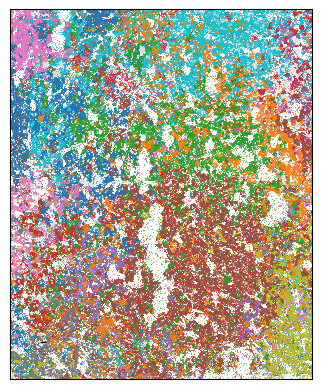

<Figure size 640x480 with 0 Axes>

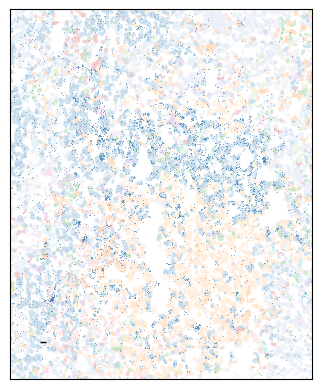

<Figure size 640x480 with 0 Axes>

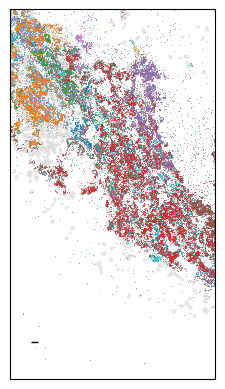

<Figure size 640x480 with 0 Axes>

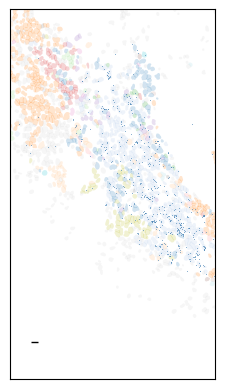

<Figure size 640x480 with 0 Axes>

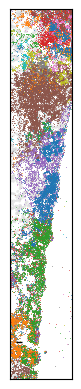

<Figure size 640x480 with 0 Axes>

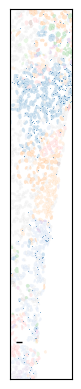

In [140]:
### PLOT SFRP1 expression and barcodes at a given location

gene_of_interest = 'SFRP1'

### zoom in to a region of interest

# box_xlims = [30000,33000]
# box_ylims = [7000,9000]

for region,lims in enumerate(box_lims[roi_of_interest]):
    box_xlims = [lims[0],lims[1]]
    box_ylims = [lims[2],lims[3]]

    spots_within = spots_df[(spots_df['x']>box_xlims[0]) & (spots_df['x']<box_xlims[1]) & (spots_df['y']>box_ylims[0]) & (spots_df['y']<box_ylims[1])]

    bc_cols = [col for col in df.columns if 'bc_' in col and 'cluster' not in col]
    # plot both the barcodes and the gene of interest in separate plots
    plt.figure()

    sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.2)

    for barcode in bc_cols:

        # get the spots for the gene of interest
        spots_gene = spots_within[spots_within['name']==barcode]

        plt.scatter(spots_gene['x'],spots_gene['y'],s=1,alpha=1.0,lw=0,marker='.')

    # plt.axis('off')
    plt.gca().tick_params(bottom=False, left=False)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    # plt.title(gene_of_interest)
    # plt.gca().invert_yaxis()
        
    plt.xlim(box_xlims[0],box_xlims[1])
    plt.ylim(box_ylims[0],box_ylims[1])


    scale_bar_length_um = 20 # 100um scale bar
    scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
    scale_bar = matplotlib.patches.Rectangle((box_xlims[0]+(0.1*(box_xlims[1]-box_xlims[0])),box_ylims[1]-(0.1*(box_ylims[1]-box_ylims[0]))), 
                                            scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
    plt.gca().add_patch(scale_bar)

    plt.gca().invert_yaxis()

    # plt.savefig(f'../graphs/in_vivo_barcode_transcripts_zoom.pdf',bbox_inches='tight',transparent=True)
    plt.savefig(f'../graphs/other_rois/{roi_of_interest}/{roi_of_interest}_region{region}_barcodes.png',dpi=1000,bbox_inches='tight',transparent=True)

    plt.figure()

    sg_obj.gdf.plot(column='bc_cluster',categorical=True,lw=0.01,alpha=0.2,missing_kwds= dict(color = "lightgrey",),cmap='tab20')


    # for gene_of_interest in bc_cols:

        # get the spots for the gene of interest
    spots_gene = spots_within[spots_within['name']==gene_of_interest]
    plt.scatter(spots_gene['x'],spots_gene['y'],s=1,alpha=1.0,lw=0,marker='.',c='steelblue')

    # plt.axis('off')
    plt.gca().tick_params(bottom=False, left=False)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    # plt.title(gene_of_interest)
    # plt.gca().invert_yaxis()
        
    plt.xlim(box_xlims[0],box_xlims[1])
    plt.ylim(box_ylims[0],box_ylims[1])


    scale_bar_length_um = 20 # 100um scale bar
    scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
    scale_bar = matplotlib.patches.Rectangle((box_xlims[0]+(0.1*(box_xlims[1]-box_xlims[0])),box_ylims[1]-(0.1*(box_ylims[1]-box_ylims[0]))), 
                                            scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
    plt.gca().add_patch(scale_bar)

    plt.gca().invert_yaxis()

    # plt.savefig(f'../graphs/in_vivo_barcode_transcripts_zoom.pdf',bbox_inches='tight',transparent=True)
    plt.savefig(f'../graphs/other_rois/{roi_of_interest}/{roi_of_interest}_region{region}_{gene_of_interest}.png',dpi=1000,bbox_inches='tight',transparent=True)


In [166]:
# filter the gdf to cells within the bbox

this_box_lims = box_lims[roi_of_interest][1]

# this_region = large_clusters_gdf.cx[(box(*box_lims[roi_of_interest][1]))]

gdf_within_box = large_clusters_gdf.cx[this_box_lims[0]:this_box_lims[1], this_box_lims[2]:this_box_lims[3]]
gdf_within_box.groupby('bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)
# this_region.groupby('bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

bc_cluster
698.0     1.000000
205.0     0.850575
545.0     0.500000
758.0     0.444444
99.0      0.444444
15.0      0.166667
526.0     0.166667
2944.0    0.140351
154.0     0.041667
418.0     0.024590
Name: SFRP1, dtype: float64

In [160]:
print(box(*box_lims[roi_of_interest][1]))

POLYGON ((48000 23000, 48000 57000, 18000 57000, 18000 23000, 48000 23000))


In [170]:
large_clusters_gdf[large_clusters_gdf['bc_cluster']==205]

nucleus  \
69215  POLYGON ((20315.000 49324.000, 20329.000 49330...   
69238  POLYGON ((20211.000 49351.000, 20225.000 49351...   
69242  POLYGON ((20461.000 49355.000, 20471.000 49357...   
69344  POLYGON ((20430.000 49478.000, 20456.000 49478...   
69365  POLYGON ((19876.000 49506.000, 19895.000 49508...   
...                                                  ...   
74383  POLYGON ((23325.000 54677.000, 23333.000 54677...   
74486  POLYGON ((23536.000 54765.000, 23553.000 54766...   
74550  POLYGON ((23428.000 54821.000, 23431.000 54824...   
74707  POLYGON ((24002.000 54945.000, 24010.000 54949...   
74787  POLYGON ((23633.000 55006.000, 23670.000 55006...   

                                         nucleus_dilated  \
69215  POLYGON ((20305.570 49320.672, 20300.020 49336...   
69238  POLYGON ((20205.516 49342.642, 20198.905 49342...   
69242  POLYGON ((20457.838 49345.513, 20436.838 49352...   
69344  POLYGON ((20428.039 49468.194, 20418.039 49470...   
69365  POLYGON ((19872.543 49496.617, 19853.543 49503...   
...                                                  ...   
74383  POLYGON ((23321.838 54667.513, 23312.838 54670...   
74486  POLYGON ((23532.527 54755.623, 23505.527 54765...   
74550  POLYGON ((23420.929 54813.929, 23401.929 54832...   
74707  POLYGON ((23993.024 54940.591, 23965.386 54996...   
74787  POLYGON ((23611.737 55137.736, 23611.922 55138...   

                  nucleus_centroid      center_x      center_y          area  \
69215  POINT (20324.164 49415.353)  20324.163670  49415.353233  16615.964724   
69238  POINT (20219.237 49414.001)  20219.236644  49414.000774  12841.171768   
69242  POINT (20450.601 49402.054)  20450.601058  49402.053906   8678.131073   
69344  POINT (20431.230 49515.904)  20431.230270  49515.904399   7045.040107   
69365  POINT (19889.578 49575.297)  19889.577662  49575.297434  15017.526517   
...                            ...           ...           ...           ...   
74383  POINT (23331.161 54747.228)  23331.160911  54747.228280  12878.933653   
74486  POINT (23545.217 54840.371)  23545.217386  54840.370918  19857.796166   
74550  POINT (23445.168 54857.717)  23445.168184  54857.717289   6432.836547   
74707  POINT (23988.183 55018.149)  23988.183115  55018.148713  10247.827283   
74787  POINT (23635.880 55070.253)  23635.879602  55070.253075  20057.052374   

      object_id cell_id  AKT1  AXL  ...  bc_093  bc_094  bc_095  bc_096  \
69215     72292   72292   1.0  2.0  ...     0.0     0.0     0.0     0.0   
69238     72312   72312   0.0  2.0  ...     0.0     0.0     0.0     0.0   
69242     72316   72316   1.0  0.0  ...     0.0     0.0     0.0     0.0   
69344     72408   72408   2.0  0.0  ...     0.0     0.0     0.0     0.0   
69365     72427   72427   3.0  0.0  ...     0.0     0.0     0.0     0.0   
...         ...     ...   ...  ...  ...     ...     ...     ...     ...   
74383     76944   76944   3.0  0.0  ...     0.0     0.0     0.0     0.0   
74486     77036   77036  11.0  0.0  ...     0.0     0.0     0.0     0.0   
74550     77094   77094   3.0  0.0  ...     0.0     0.0     0.0     0.0   
74707     77235   77235   0.0  0.0  ...     0.0     1.0     0.0     0.0   
74787     77307   77307   3.0  0.0  ...     0.0     2.0     0.0     0.0   

       bc_cluster  bc_cluster_bc_names  bc_cluster_found_bcs  \
69215       205.0        bc_030-bc_074  ['bc_030', 'bc_074']   
69238       205.0        bc_030-bc_074  ['bc_030', 'bc_074']   
69242       205.0        bc_030-bc_074  ['bc_030', 'bc_074']   
69344       205.0        bc_030-bc_074  ['bc_030', 'bc_074']   
69365       205.0        bc_030-bc_074  ['bc_030', 'bc_074']   
...           ...                  ...                   ...   
74383       205.0        bc_030-bc_074  ['bc_030', 'bc_074']   
74486       205.0        bc_030-bc_074  ['bc_030', 'bc_074']   
74550       205.0        bc_030-bc_074  ['bc_030', 'bc_074']   
74707       205.0        bc_030-bc_074  ['bc_030', 'bc_074']   
74787       205.0        bc_030-bc_074  [

In [161]:
large_clusters_gdf[large_clusters_gdf['bc_cluster']==69]

nucleus  \
42119  POLYGON ((2778.000 25696.000, 2805.000 25704.0...   
42393  POLYGON ((2755.000 25790.000, 2758.000 25790.0...   
43154  POLYGON ((2865.000 26089.000, 2885.000 26094.0...   
43383  POLYGON ((2802.000 26169.000, 2830.000 26180.0...   
44033  POLYGON ((2682.000 26431.000, 2696.000 26431.0...   
44341  POLYGON ((3077.000 26544.000, 3094.000 26545.0...   
44490  POLYGON ((2774.000 26598.000, 2821.000 26603.0...   
44789  POLYGON ((3080.000 26700.000, 3097.000 26700.0...   
44812  POLYGON ((3156.000 26709.000, 3176.000 26711.0...   
44975  POLYGON ((3191.000 26758.000, 3198.000 26762.0...   
50652  POLYGON ((21233.000 28885.000, 21248.000 28885...   
50749  POLYGON ((21317.000 28922.000, 21322.000 28922...   
50821  POLYGON ((21372.000 28956.000, 21395.000 28958...   
60672  POLYGON ((11703.000 35722.000, 11747.000 35725...   
60958  POLYGON ((11422.000 36308.000, 11438.000 36310...   
61070  POLYGON ((10813.000 36495.000, 10826.000 36495...   
61196  POLYGON ((10665.000 36724.000, 10678.000 36736...   
61231  POLYGON ((10461.000 36785.000, 10463.000 36785...   
61248  POLYGON ((10381.000 36810.000, 10383.000 36810...   
61491  POLYGON ((10804.000 37234.000, 10834.000 37262...   

                                         nucleus_dilated  \
42119  POLYGON ((2746.038 25789.166, 2746.000 25790.0...   
42393  POLYGON ((2750.200 25781.229, 2749.644 25781.1...   
43154  POLYGON ((2804.221 26179.276, 2804.287 26179.3...   
43383  POLYGON ((2794.473 26162.434, 2780.324 26166.3...   
44033  POLYGON ((2679.490 26421.320, 2652.490 26428.3...   
44341  POLYGON ((3031.000 26584.980, 3031.000 26586.0...   
44490  POLYGON ((2766.191 26591.753, 2754.191 26606.7...   
44789  POLYGON ((3077.127 26690.422, 3067.127 26693.4...   
44812  POLYGON ((3154.440 26699.122, 3135.440 26702.1...   
44975  POLYGON ((3129.431 26839.881, 3134.753 26852.8...   
50652  POLYGON ((21229.583 28875.602, 21220.848 28878...   
50749  POLYGON ((21309.567 28915.310, 21300.567 28925...   
50821  POLYGON ((21369.423 28946.338, 21354.423 28950...   
60672  POLYGON ((11696.903 35714.074, 11684.960 35723...   
60958  POLYGON ((11417.862 36298.896, 11406.862 36303...   
61070  POLYGON ((10807.000 36487.000, 10787.000 36502...   
61196  POLYGON ((10660.181 36715.238, 10640.857 36725...   
61231  POLYGON ((10393.774 36867.595, 10396.461 36868...   
61248  POLYGON ((10326.773 36854.915, 10327.850 36855...   
61491  POLYGON ((10795.056 37229.528, 10794.950 37229...   

                  nucleus_centroid      center_x      center_y          area  \
42119   POINT (2812.125 25769.646)   2812.124789  25769.645854  16058.714039   
42393   POINT (2783.027 25852.092)   2783.026548  25852.092271  12028.718461   
43154   POINT (2900.886 26187.469)   2900.886210  26187.469244  27924.002412   
43383   POINT (2836.096 26254.075)   2836.095684  26254.075189  22439.497677   
44033   POINT (2694.221 26523.148)   2694.221208  26523.147858  21152.674686   
44341   POINT (3096.605 26587.699)   3096.604933  26587.698994  11727.664014   
44490   POINT (2794.375 26669.412)   2794.375276  26669.412009  16456.574340   
44789   POINT (3086.657 26725.914)   3086.657340  26725.913622   5234.913445   
44812   POINT (3150.391 26751.015)   3150.391353  26751.015182   8154.358369   
44975   POINT (3193.751 26810.911)   3193.750871  26810.910864  13388.441972   
50652  POINT (21242.459 28916.950)  21242.459307  28916.949940   6657.107720   
50749  POINT (21321.655 28972.394)  21321.654881  28972.394158   6967.882876   
50821  POINT (21376.555 29002.589)  21376.555220  29002.588907  10723.928502   
60672  POINT (11734.025 35801.084)  11734.024628  35801.084376  23757.241595   
60958  POINT (11424.136 36346.840)  11424.136095  36346.840008   6576.631752   
61070  POINT (10835.056 36540.295)  10835.055570  36540.294633  11366.550571   
61196  POINT (10647.543 36776.076)  10647.543043  36776.075661   8544.032871   
61231  POINT (10433.276 36828.352)  10433.276277  36828.351715  10836.674519   
61248  

In [31]:
### what are the barcodes associated with this cluster???

gdf_within_box = large_clusters_gdf.cx[box_xlims[0]:box_xlims[1], box_ylims[0]:box_ylims[1]]
gdf_within_box.groupby('bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

gdf_within_box[gdf_within_box['bc_cluster'] == 40][['bc_cluster','bc_cluster_bc_names','SFRP1']]
# .isin([reg])

cluster_of_interest = 40

neighboring_cells = gdf_within_box[~(gdf_within_box['bc_cluster'] == cluster_of_interest)]['cell_id'].values

In [182]:
from shapely.geometry import Point
from shapely.ops import unary_union
import geopandas as gpd

# Get your cluster cells
cluster_cells = sg_obj.gdf[sg_obj.gdf['bc_cluster'] == 40]
# cluster_cells['geometry'] = cluster_cells['nucleus_centroid']


# Convert distance from um to pixels
distance_um = 30  # 30um is roughly 3 cell lengths
distance_px = distance_um / tools.sg_pixel_size  # Simplified conversion

# Method 1: Using buffer and spatial join
# Create a buffer around all cluster cells
cluster_union = unary_union(cluster_cells.geometry)
buffer_zone = cluster_union.buffer(distance_px)

# Find all cells that intersect with the buffer zone
neighboring_cells = sg_obj.gdf[sg_obj.gdf.geometry.intersects(buffer_zone)]

# If you want to exclude the original cluster cells from the result
neighboring_cells_only = neighboring_cells[neighboring_cells['bc_cluster'] != 40]


In [183]:
neighboring_cells_only

nucleus  \
28448  POLYGON ((7807.000 20515.000, 7822.000 20517.0...   
28566  POLYGON ((7999.000 20551.000, 8003.000 20551.0...   
28883  POLYGON ((7979.000 20652.000, 7986.000 20657.0...   
29042  POLYGON ((7958.000 20700.000, 7975.000 20707.0...   
30126  POLYGON ((18512.000 21062.000, 18529.000 21066...   
...                                                  ...   
74219  POLYGON ((26779.000 54541.000, 26790.000 54541...   
74252  POLYGON ((26641.000 54578.000, 26658.000 54578...   
74331  POLYGON ((26886.000 54639.000, 26895.000 54640...   
74366  POLYGON ((26959.000 54663.000, 26973.000 54664...   
74419  POLYGON ((27002.000 54709.000, 27005.000 54711...   

                                         nucleus_dilated  \
28448  POLYGON ((7801.700 20506.520, 7793.700 20511.5...   
28566  POLYGON ((7996.991 20541.204, 7957.991 20549.2...   
28883  POLYGON ((7977.039 20642.194, 7967.039 20644.1...   
29042  POLYGON ((7949.230 20695.205, 7948.930 20695.3...   
30126  POLYGON ((18490.159 21174.823, 18506.454 21193...   
...                                                  ...   
74219  POLYGON ((26774.211 54532.221, 26764.797 54537...   
74252  POLYGON ((26639.356 54568.136, 26627.356 54570...   
74331  POLYGON ((26882.410 54629.667, 26872.360 54633...   
74366  POLYGON ((26954.528 54654.056, 26944.528 54659...   
74419  POLYGON ((26961.053 54731.929, 26955.000 54740...   

                  nucleus_centroid      center_x      center_y          area  \
28448   POINT (7827.633 20592.507)   7827.632686  20592.507257  12654.298312   
28566   POINT (7984.259 20601.761)   7984.259111  20601.760916  10569.844399   
28883   POINT (7987.271 20696.974)   7987.271298  20696.973528   5904.479452   
29042   POINT (7948.235 20759.906)   7948.234501  20759.906402  13139.899539   
30126  POINT (18513.656 21120.588)  18513.656488  21120.588133  10180.641260   
...                            ...           ...           ...           ...   
74219  POINT (26770.854 54581.729)  26770.853943  54581.729184   7815.816069   
74252  POINT (26654.678 54619.278)  26654.677509  54619.277829   9037.765982   
74331  POINT (26881.123 54720.005)  26881.122504  54720.005183  13054.811685   
74366  POINT (26969.014 54696.305)  26969.014438  54696.304692   6038.705742   
74419  POINT (27004.779 54759.769)  27004.779238  54759.769027  10942.672135   

      object_id cell_id  AKT1  AXL  ...  bc_093  bc_094  bc_095  bc_096  \
28448     35601   35601   7.0  0.0  ...     0.0     0.0     0.0     0.0   
28566     35708   35708   3.0  0.0  ...     0.0     0.0     0.0     0.0   
28883     35994   35994   2.0  0.0  ...     0.0     0.0     0.0     0.0   
29042     36136   36136   5.0  1.0  ...     0.0     0.0     0.0     0.0   
30126     37111   37111   0.0  0.0  ...     0.0     0.0     0.0     0.0   
...         ...     ...   ...  ...  ...     ...     ...     ...     ...   
74219     76797   76797   0.0  0.0  ...     0.0     0.0     0.0     0.0   
74252     76826   76826   1.0  0.0  ...     0.0     1.0     1.0     0.0   
74331     76898   76898   1.0  0.0  ...     0.0     0.0     0.0     0.0   
74366     76929   76929   0.0  0.0  ...     0.0     1.0    19.0     0.0   
74419     76977   76977   0.0  0.0  ...     0.0     0.0     0.0     0.0   

       bc_cluster          bc_cluster_bc_names  \
28448       767.0  bc_030-bc_038-bc_040-bc_060   
28566      1109.0                bc_060-bc_073   
28883      1109.0                bc_060-bc_073   
29042       625.0         bc_030-bc_038-bc_073   
30126         NaN                          NaN   
...           ...                          ...   
74219       445.0         bc_022-bc_041-bc_073   
74252       445.0         bc_022-bc_041-bc_073   
74331       773.0         bc_041-bc_073-bc_085   
74366      2043.0         bc_044-bc_073-bc_095   
74419       445.0         bc_022-bc_041-bc_073   

                           bc_cluster_found_bcs  bc_cluster_n_bcs  \
28448  ['bc_030', 'bc_038', 'bc_040', 'bc_060']               4.0   
28566 

In [186]:
sg_obj.gdf['SFRP1'].tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

T-statistic: 13.242999396342638, P-value: 8.245163106774e-38


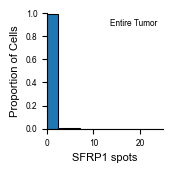

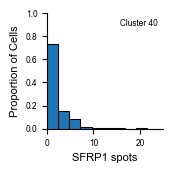

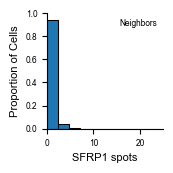

In [194]:
# now let's plot the distributino of clones within the clone, compared to neighboring cells and the entire tumor

cluster_of_interest = 40
# map nan to 0
counts, bins = np.histogram(sg_obj.gdf['SFRP1'].dropna().tolist(),)

# counts,bins = np.histogram(sg_obj.gdf['SFRP1'].dropna().tolist(),)

# counts,bins = np.histogram(sg_obj.gdf['SFRP1'].tolist(),)
plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Entire Tumor',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(sg_obj.gdf['SFRP1'].dropna().tolist(),bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)


plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# entire tumor
# ax = plt.subplot(1,3,3)
plt.text(s=f'Cluster {cluster_of_interest}',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Entire tumor')
sns.histplot(cluster_cells['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_histograms_clone.pdf',bbox_inches='tight',transparent=True)


plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(neighboring_cells_only['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_histograms_neighbors.pdf',bbox_inches='tight',transparent=True)

# statstical test that means are different between the cluster and neighbors

from scipy.stats import ttest_ind
# t-test between the cluster and neighboring cells
t_stat, p_val = ttest_ind(cluster_cells['SFRP1'].dropna(), neighboring_cells_only['SFRP1'].dropna())
print(f'T-statistic: {t_stat}, P-value: {p_val}')

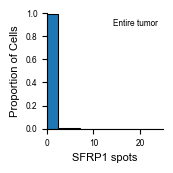

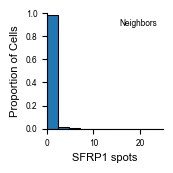

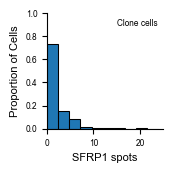

In [37]:
#### plot distributions of counts within the clone, compared to its neighborhood and the entire tumor 
# plt.subplots(figsize=(12,4),sharex=True,sharey=True)
# non_zero_cells = df[df['SFRP1']>1]
counts,bins = np.histogram(df['SFRP1'])

cluster_of_interest = 40

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# entire tumor
# ax = plt.subplot(1,3,3)
plt.text(s='Entire tumor',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Entire tumor')
sns.histplot(df['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_full.pdf',bbox_inches='tight',transparent=True)

# print('Entire Tumor')
# print('Mean SFRP1 epxression:',df['SFRP1'].mean())
# print('Fraction of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1)/len(df))
# print('number of cells total:',len(df))
# print('number of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(df[df['cell_id'].isin(neighboring_cells)]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_neighbors.pdf',bbox_inches='tight',transparent=True)

# print('Neighbors')
# print('Mean SFRP1 expression:',df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'].mean())
# print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1)/len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
# print('number of cells total:',len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
# print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# clone 31
# ax = plt.subplot(1,3,1)
plt.text(s='Clone cells',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
sns.histplot(df[df['bc_cluster'].isin([40])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_hists.pdf',bbox_inches='tight')
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_clone31.pdf',bbox_inches='tight',transparent=True)

# print('clone 31')
# print('Mean SFRP1 expression:',df[df['bc_cluster'].isin([40])]['SFRP1'].mean())
# print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1)/len(df[df['object_id'].isin(manual_cluster['object_id'])]))
# print('number of cells total:',len(df[df['object_id'].isin(manual_cluster['object_id'])]))
# print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1))


# fig,ax = plt.subplots(figsize=(1.5,1.5))

# # entire tumor
# ax.scatter([tools.jitter_point(0,0.1) for x in df['SFRP1']],
#             df['SFRP1'],alpha=0.2)


# # neighbors
# neighbors = df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]
# ax.scatter([tools.jitter_point(1,0.1) for x in neighbors['SFRP1']],
#             neighbors['SFRP1'],alpha=0.2)

# # clone 31
# ax.scatter([tools.jitter_point(2,0.1) for x in df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']],
#             df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],alpha=0.2)
# # sns.histplot(,bins=bins,alpha=1.0,stat='proportion',ax=ax)

# plt.xticks(range(3),['entire tumor','Neighbors','Clone 31 cells'])
# # plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_jitter.pdf',bbox_inches='tight')

# fig,ax = plt.subplots(figsize=(4,4))
# plt.plot(np.linspace(0,1,len(df['SFRP1'])),
#          np.cumsum(df['SFRP1'].sort_values(ascending=False).values)/np.sum(df['SFRP1']),
#          label='Entire tumor')
# plt.plot(np.linspace(0,1,len(neighbors['SFRP1'])),
#          np.cumsum(neighbors['SFRP1'].sort_values(ascending=False).values)/np.sum(neighbors['SFRP1']),
#          label='Neighbors')
# plt.plot(np.linspace(0,1,len(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'])),
#          np.cumsum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].sort_values(ascending=False).values)/np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']),
#          label='Clone 31 cells')
# plt.legend()

# plt.ylabel('Cumulative proportion of spots')
# plt.xlabel('Proportion of cells in group (sorted)')



bc_cluster bc_cluster_bc_names  SFRP1
30244        40.0              bc_073    4.0
31394        40.0              bc_073    3.0
31510        40.0              bc_073    2.0
31959        40.0              bc_073    0.0
32075        40.0              bc_073    8.0
...           ...                 ...    ...
52992        40.0              bc_073    0.0
53151        40.0              bc_073    1.0
53213        40.0              bc_073    3.0
53352        40.0              bc_073    4.0
53427        40.0              bc_073    4.0

[491 rows x 3 columns]

<AxesSubplot: >

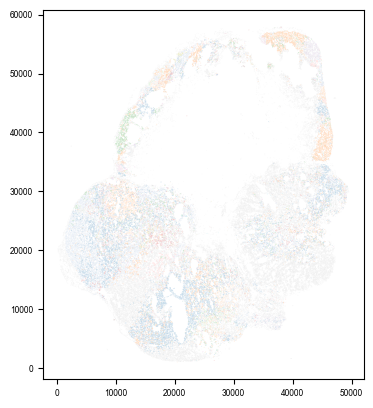

In [174]:
sg_obj.gdf.plot(column='bc_cluster',categorical=True,lw=0.01,alpha=0.2,missing_kwds= dict(color = "lightgrey",),cmap='tab20')

In [130]:
box_lims[roi_of_interest][1]

[18000, 23000, 48000, 57000]

In [ ]:
sg_obj.gdf.within()

In [138]:
sg_obj.gdf

nucleus  \
0      POLYGON ((20452.000 978.000, 20472.000 980.000...   
1      POLYGON ((20899.000 1116.000, 20919.000 1120.0...   
2      POLYGON ((23405.000 1289.000, 23422.000 1289.0...   
3      POLYGON ((22362.000 2604.000, 22371.000 2604.0...   
4      POLYGON ((34450.000 9802.000, 34456.000 9802.0...   
...                                                  ...   
79141  POLYGON ((21998.000 9799.000, 22000.000 9799.0...   
79142  POLYGON ((17051.000 9800.000, 17090.000 9803.0...   
79143  POLYGON ((25990.000 9800.000, 26006.000 9801.0...   
79144  POLYGON ((29231.000 9800.000, 29239.000 9800.0...   
79145  POLYGON ((13872.000 9801.000, 13898.000 9858.0...   

                                         nucleus_dilated  \
0      POLYGON ((20366.000 1040.661, 20365.685 1041.3...   
1      POLYGON ((20893.700 1107.520, 20885.700 1112.5...   
2      POLYGON ((23401.154 1279.769, 23389.154 1284.7...   
3      POLYGON ((22354.191 2597.753, 22350.191 2602.7...   
4      POLYGON ((34410.776 9860.918, 34421.929 9872.0...   
...                                                  ...   
79141  POLYGON ((21994.227 9789.739, 21968.317 9800.2...   
79142  POLYGON ((17048.710 9790.266, 17031.710 9794.2...   
79143  POLYGON ((25985.528 9791.056, 25975.528 9796.0...   
79144  POLYGON ((29224.753 9792.191, 29214.753 9800.1...   
79145  POLYGON ((13869.341 9791.360, 13840.341 9799.3...   

                 nucleus_centroid      center_x     center_y          area  \
0      POINT (20442.252 1036.183)  20442.252084  1036.182508  14465.012042   
1      POINT (20934.446 1155.448)  20934.446389  1155.447838   8310.292671   
2      POINT (23427.302 1328.096)  23427.302149  1328.095541   8030.740341   
3      POINT (22391.950 2660.513)  22391.949684  2660.512711   7791.201110   
4      POINT (34434.629 9833.058)  34434.628857  9833.058403   4928.902676   
...                           ...           ...          ...           ...   
79141  POINT (21987.939 9828.897)  21987.939394  9828.897300   5500.544273   
79142  POINT (17057.349 9832.790)  17057.348683  9832.790086   7029.281662   
79143  POINT (26005.495 9880.858)  26005.494746  9880.858088  20049.671924   
79144  POINT (29248.028 9850.902)  29248.027506  9850.902230   5990.908719   
79145  POINT (13862.484 9865.244)  13862.483910  9865.244236  12053.901189   

      object_id cell_id  AKT1  AXL  ...  bc_093  bc_094  bc_095  bc_096  \
0             1       1   1.0  0.0  ...     0.0     0.0     1.0     0.0   
1            10      10   2.0  0.0  ...     0.0     0.0     0.0     0.0   
2           100     100   5.0  0.0  ...     0.0     0.0     0.0     0.0   
3          1000    1000   1.0  0.0  ...     0.0     0.0     0.0     0.0   
4         10000   10000   1.0  0.0  ...     0.0     0.0     0.0     0.0   
...         ...     ...   ...  ...  ...     ...     ...     ...     ...   
79141      9995    9995   0.0  0.0  ...     0.0     0.0     0.0     0.0   
79142      9996    9996   1.0  0.0  ...     0.0     0.0     0.0     0.0   
79143      9997    9997   4.0  0.0  ...     0.0     0.0     0.0     0.0   
79144      9998    9998   3.0  0.0  ...     0.0     0.0     0.0     0.0   
79145      9999    9999   4.0  0.0  ...     0.0     0.0     0.0     0.0   

       bc_cluster   bc_cluster_bc_names            bc_cluster_found_bcs  \
0           705.0                bc_074                      ['bc_074']   
1             NaN                   NaN                             NaN   
2             NaN                   NaN                             NaN   
3             NaN                   NaN                             NaN   
4             NaN                   NaN                             NaN   
...           ...                   ...                             ...   
79141       410.0  bc_001-bc_031-bc_087  ['bc_001', 'bc_031', 'bc_087']   
79142         NaN                   NaN                             NaN   
79143        90.0  bc_060-bc_077-bc_092  ['bc_060', 'bc_077', 'bc_092']   
79144         NaN  

In [136]:
# filter the gdf to cells within the bbox

this_region = sg_obj.gdf.loc[sg_obj.gdf.within(box(*box_lims[roi_of_interest][1]))]

In [137]:
this_region

nucleus  \
35036  POLYGON ((18157.000 23010.000, 18177.000 23011...   
35037  POLYGON ((37423.000 23010.000, 37427.000 23012...   
35039  POLYGON ((19103.000 23011.000, 19123.000 23025...   
35040  POLYGON ((19216.000 23012.000, 19242.000 23012...   
35041  POLYGON ((40481.000 23012.000, 40496.000 23014...   
...                                                  ...   
76604  POLYGON ((35191.000 56902.000, 35227.000 56903...   
76608  POLYGON ((34237.000 56912.000, 34248.000 56913...   
76613  POLYGON ((27182.000 56922.000, 27189.000 56922...   
76614  POLYGON ((36914.000 56923.000, 36947.000 56925...   
76628  POLYGON ((26743.000 56956.000, 26755.000 56956...   

                                         nucleus_dilated  \
35036  POLYGON ((18153.838 23000.513, 18147.357 23002...   
35037  POLYGON ((37414.863 23004.188, 37404.863 23018...   
35039  POLYGON ((19053.127 23018.485, 19044.243 23026...   
35040  POLYGON ((19213.127 23002.422, 19193.127 23008...   
35041  POLYGON ((40478.831 23002.238, 40469.831 23004...   
...                                                  ...   
76604  POLYGON ((35187.286 56892.715, 35177.286 56896...   
76608  POLYGON ((34235.039 56902.194, 34225.039 56904...   
76613  POLYGON ((27175.243 56914.628, 27163.243 56925...   
76614  POLYGON ((36904.555 56919.715, 36896.555 56942...   
76628  POLYGON ((26736.753 56948.191, 26731.753 56952...   

                  nucleus_centroid      center_x      center_y          area  \
35036  POINT (18156.052 23073.496)  18156.052035  23073.495533  15727.641955   
35037  POINT (37444.402 23065.589)  37444.402455  23065.589093   6450.640608   
35039  POINT (19082.883 23071.562)  19082.882507  23071.562116  12842.863444   
35040  POINT (19227.259 23055.240)  19227.259226  23055.240193  10550.647197   
35041  POINT (40502.027 23103.855)  40502.026976  23103.854655  18477.339100   
...                            ...           ...           ...           ...   
76604  POINT (35218.632 56925.209)  35218.632445  56925.208633   5647.510064   
76608  POINT (34235.111 56932.583)  34235.110973  56932.583333   3408.236668   
76613  POINT (27180.820 56941.893)  27180.820022  56941.893138   2349.310329   
76614  POINT (36929.716 56947.422)  36929.715994  56947.422123   3840.369813   
76628  POINT (26781.802 56972.307)  26781.801791  56972.307243   4655.745243   

      object_id cell_id  AKT1  AXL  ...  bc_093  bc_094  bc_095  bc_096  \
35036     41530   41530   1.0  1.0  ...     0.0     0.0     0.0     0.0   
35037     41531   41531   2.0  0.0  ...     0.0     0.0     0.0     1.0   
35039     41533   41533   2.0  0.0  ...     0.0     0.0     0.0     0.0   
35040     41534   41534   4.0  0.0  ...     0.0     0.0     0.0     0.0   
35041     41535   41535  14.0  1.0  ...     0.0     0.0     0.0     0.0   
...         ...     ...   ...  ...  ...     ...     ...     ...     ...   
76604     78943   78943   0.0  0.0  ...     0.0     0.0     0.0     0.0   
76608     78947   78947   0.0  0.0  ...     0.0     0.0     0.0     0.0   
76613     78951   78951   NaN  NaN  ...     NaN     NaN     NaN     NaN   
76614     78952   78952   1.0  0.0  ...     0.0     0.0     0.0     0.0   
76628     78965   78965   0.0  0.0  ...     0.0     0.0     0.0     0.0   

       bc_cluster   bc_cluster_bc_names            bc_cluster_found_bcs  \
35036         NaN                   NaN                             NaN   
35037         NaN                   NaN                             NaN   
35039      1070.0         bc_016-bc_073            ['bc_016', 'bc_073']   
35040       877.0  bc_016-bc_057-bc_073  ['bc_016', 'bc_057', 'bc_073']   
35041       488.0         bc_009-bc_039            ['bc_009', 'bc_039']   
...           ...                   ...                             ...   
76604         NaN                   NaN                             NaN   
76608         NaN                   NaN                             NaN   
76613         NaN                   NaN                             Na

Entire Tumor
Mean SFRP1 epxression: 0.10002678491711556
Fraction of cells with SFRP1 > 1: 0.015088836641766613
number of cells total: 67202
number of cells with SFRP1 > 1: 1014
Neighbors
Mean SFRP1 expression: 0.17717842323651453
Fraction of cells with SFRP1 > 1: 0.033609958506224065
number of cells total: 2410
number of cells with SFRP1 > 1: 81
clone 31
Mean SFRP1 expression: 3.7468354430379747
Fraction of cells with SFRP1 > 1: 0.5822784810126582
number of cells total: 79
number of cells with SFRP1 > 1: 46


Text(0.5, 0, 'Proportion of cells in group (sorted)')

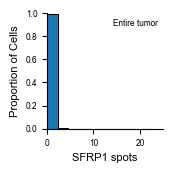

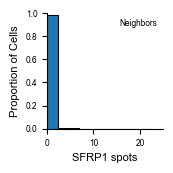

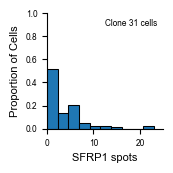

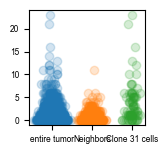

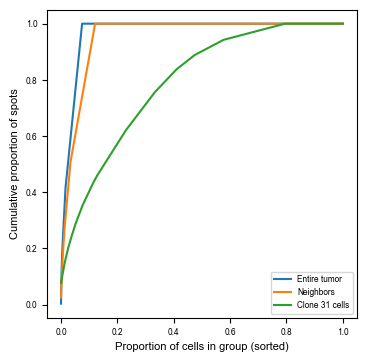

In [ ]:
#### plot distributions of counts within the clone, compared to its neighborhood and the entire tumor 
# plt.subplots(figsize=(12,4),sharex=True,sharey=True)
# non_zero_cells = df[df['SFRP1']>1]
counts,bins = np.histogram(df['SFRP1'])

cluster_of_interest = 31

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# entire tumor
# ax = plt.subplot(1,3,3)
plt.text(s='Entire tumor',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Entire tumor')
sns.histplot(df['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_full.pdf',bbox_inches='tight',transparent=True)

print('Entire Tumor')
print('Mean SFRP1 epxression:',df['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1)/len(df))
print('number of cells total:',len(df))
print('number of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_neighbors.pdf',bbox_inches='tight',transparent=True)

print('Neighbors')
print('Mean SFRP1 expression:',df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1)/len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells total:',len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# clone 31
# ax = plt.subplot(1,3,1)
plt.text(s='Clone 31 cells',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
sns.histplot(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_hists.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_clone31.pdf',bbox_inches='tight',transparent=True)

print('clone 31')
print('Mean SFRP1 expression:',df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1)/len(df[df['object_id'].isin(manual_cluster['object_id'])]))
print('number of cells total:',len(df[df['object_id'].isin(manual_cluster['object_id'])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1))


fig,ax = plt.subplots(figsize=(1.5,1.5))

# entire tumor
ax.scatter([tools.jitter_point(0,0.1) for x in df['SFRP1']],
            df['SFRP1'],alpha=0.2)


# neighbors
neighbors = df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]
ax.scatter([tools.jitter_point(1,0.1) for x in neighbors['SFRP1']],
            neighbors['SFRP1'],alpha=0.2)

# clone 31
ax.scatter([tools.jitter_point(2,0.1) for x in df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']],
            df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],alpha=0.2)
# sns.histplot(,bins=bins,alpha=1.0,stat='proportion',ax=ax)

plt.xticks(range(3),['entire tumor','Neighbors','Clone 31 cells'])
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_jitter.pdf',bbox_inches='tight')

fig,ax = plt.subplots(figsize=(4,4))
plt.plot(np.linspace(0,1,len(df['SFRP1'])),
         np.cumsum(df['SFRP1'].sort_values(ascending=False).values)/np.sum(df['SFRP1']),
         label='Entire tumor')
plt.plot(np.linspace(0,1,len(neighbors['SFRP1'])),
         np.cumsum(neighbors['SFRP1'].sort_values(ascending=False).values)/np.sum(neighbors['SFRP1']),
         label='Neighbors')
plt.plot(np.linspace(0,1,len(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'])),
         np.cumsum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].sort_values(ascending=False).values)/np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']),
         label='Clone 31 cells')
plt.legend()

plt.ylabel('Cumulative proportion of spots')
plt.xlabel('Proportion of cells in group (sorted)')



In [83]:
# plot SFRP1 spots for the whole roi

# open spots file
spots_df = pd.read_csv(tools.roi_file_paths[roi_of_interest]["spots_file"])

<Figure size 640x480 with 0 Axes>

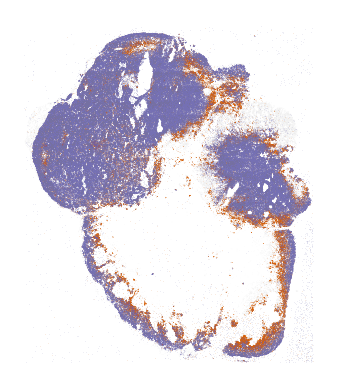

In [86]:
# plt.figure()
gene_of_interest = 'SFRP1'

gene_list = ['VEGFA',
             'MITF',
            #  'SPARC',
            'SFRP1',
                ]

gene_list = ['VEGFA',
             'MITF',
            #  'SPARC',
            # 'SFRP1',
                ]

gene_colors = {'VEGFA':'b',
               'MITF':'r',}

gene_colors = {
                # 'VEGFA':'#5e3c99',
               'VEGFA':'#d95f02',
               
            #    'MITF':'#e66101',
               'MITF':'#7570b3',
               
               }


plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)

for gene_of_interest in gene_list:

    # get the spots for the gene of interest
    spots_gene = spots_df[spots_df['name']==gene_of_interest]


    plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0,color=gene_colors[gene_of_interest])

plt.axis('off')
# plt.title(gene_of_interest)
plt.gca().invert_yaxis()

# plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_VEGFA_MITF_full.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_VEGFA_MITF_full.png',dpi=500,bbox_inches='tight',transparent=True)

    

In [1]:
# plt.figure()
gene_of_interest = 'SFRP1'


plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)
spots_gene = spots_df[spots_df['name']==gene_of_interest]
plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0,color='b')

# plt.axis('off')
# plt.title(gene_of_interest)
plt.gca().invert_yaxis()

# plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_SFRP1_full.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/other_rois/{roi_of_interest}_space_SFRP1_full.png',dpi=500,bbox_inches='tight',transparent=True)
# plt.savefig(f'../graphs/space_VEGFA_MITF_full.png',dpi=500,bbox_inches='tight',transparent=True)

    

NameError: name 'plt' is not defined

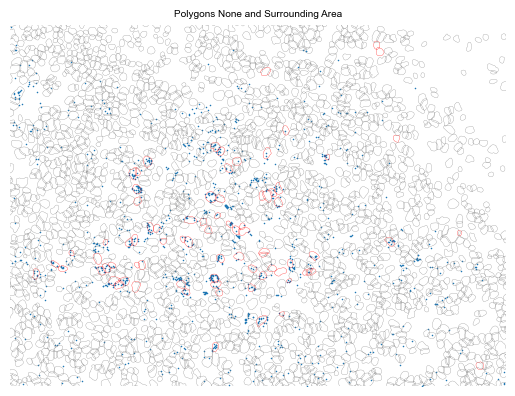

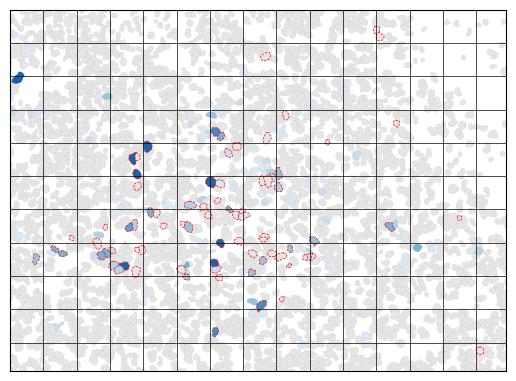

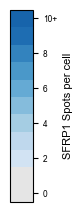

In [18]:
# comparision to grid-based spatial transcriptomics technologies

gene_of_interest = 'SFRP1'
cluster_of_interest = 31

# get the cells associated with the manual cluster
cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)
central_ix = int(len(cluster_cells)/2) 
cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=1,id_field='cell_id')

fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 2
vmax = 10

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

bbox = box(xmin,ymin,xmax,ymax)
other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

cmap = matplotlib.cm.get_cmap('Blues').copy()
cmap = cmap(np.linspace(0.15, 0.8, 256))

cmap = matplotlib.colors.ListedColormap(cmap)
cmap.set_under('#e5e5e5') # set low values to gray

merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

# visium HD has theoretical 2 micron grid size. This is roughly every 2000/107 = 18.7 pixels
# plt.gca().set_xticks([xmin+18.7*i for i in range(int((xmax-xmin)/18.7)+1)])
# plt.gca().set_yticks([ymin+18.7*i for i in range(int((ymax-ymin)/18.7)+1)])

# visium HD has 8 micron grid size as recommended resolution. This is roughly every 8000/107 =74.77 pixels
# plt.gca().set_xticks([xmin+74.77*i for i in range(int((xmax-xmin)/74.77)+1)])
# plt.gca().set_yticks([ymin+74.77*i for i in range(int((ymax-ymin)/74.77)+1)])

# visium has 55 micron grid size. This is roughly every 55000/107 = 514 pixels
plt.gca().set_xticks([xmin+514*i for i in range(int((xmax-xmin)/514)+1)])
plt.gca().set_yticks([ymin+514*i for i in range(int((ymax-ymin)/514)+1)])
plt.gca().tick_params(which='major', color='k',length=0)
plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

# plt.gca().tick_params()

ax.tick_params(axis='both', which='major', labelsize=5)
ax.tick_params(axis='both', which='minor', labelsize=2)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_zoom_grid.pdf',bbox_inches='tight')



### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(0.3,2.5))
# cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
#                             norm=norm,
#                             orientation='vertical')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])
# ax.set_yticks([x+0.5 for x in [0,2,4,6,8,10]],[0,2,4,6,8,10])

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_colorbar_grayed_grid.pdf',bbox_inches='tight',transparent=True)


# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')



In [19]:
gene_of_interest = 'SFRP1'
cluster_of_interest = 31

# get the cells associated with the manual cluster
cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)
central_ix = int(len(cluster_cells)/2) 
cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

In [20]:
region

nucleus  \
22042  POLYGON ((9717.000 22600.000, 9735.000 22600.0...   
22071  POLYGON ((9534.000 22614.000, 9554.000 22619.0...   
22075  POLYGON ((9803.000 22617.000, 9813.000 22617.0...   
22098  POLYGON ((10294.000 22627.000, 10307.000 22632...   
22104  POLYGON ((10597.000 22628.000, 10608.000 22632...   
...                                                  ...   
28678  POLYGON ((11727.000 26202.000, 11745.000 26202...   
28696  POLYGON ((11394.000 26213.000, 11396.000 26217...   
28699  POLYGON ((9508.000 26214.000, 9509.000 26217.0...   
28700  POLYGON ((10305.000 26214.000, 10316.000 26215...   
28713  POLYGON ((11816.000 26221.000, 11849.000 26224...   

                                         nucleus_dilated  \
22042  POLYGON ((9634.000 22672.019, 9633.716 22672.3...   
22071  POLYGON ((9530.286 22604.715, 9505.286 22614.7...   
22075  POLYGON ((9799.989 22607.464, 9781.922 22613.1...   
22098  POLYGON ((10285.679 22621.453, 10285.677 22621...   
22104  POLYGON ((10564.911 22726.037, 10567.152 22738...   
...                                                  ...   
28678  POLYGON ((11708.009 26277.187, 11708.050 26278...   
28696  POLYGON ((11389.795 26203.927, 11348.795 26222...   
28699  POLYGON ((9499.176 26209.294, 9483.176 26239.2...   
28700  POLYGON ((10301.672 26204.570, 10284.672 26210...   
28713  POLYGON ((11740.619 26241.566, 11740.335 26242...   

                  nucleus_centroid      center_x      center_y          area  \
22042   POINT (9709.981 22691.239)   9709.981075  22691.239367  22882.252109   
22071   POINT (9522.313 22687.887)   9522.313194  22687.886842  18887.967022   
22075   POINT (9803.283 22680.617)   9803.282576  22680.617043  13631.535890   
22098  POINT (10301.614 22698.610)  10301.614233  22698.610197  13338.203270   
22104  POINT (10604.700 22697.795)  10604.700122  22697.794656  10563.854325   
...                            ...           ...           ...           ...   
28678  POINT (11731.427 26236.393)  11731.426838  26236.392676   5600.912270   
28696  POINT (11375.828 26283.604)  11375.828172  26283.604256  15653.183784   
28699   POINT (9490.126 26326.838)   9490.125765  26326.837807  17228.114514   
28700  POINT (10327.154 26257.377)  10327.154210  26257.376605  10103.251840   
28713  POINT (11805.474 26267.522)  11805.474470  26267.521855  14008.609315   

      object_id cell_id  AKT1  AXL  ...  bc_093  bc_094  bc_095  bc_096  \
22042     29837   29837   8.0  0.0  ...     0.0     0.0     0.0     0.0   
22071     29863   29863   3.0  0.0  ...     0.0     0.0     0.0     0.0   
22075     29867   29867   1.0  0.0  ...     0.0     0.0     0.0     0.0   
22098     29888   29888   2.0  0.0  ...     0.0     0.0     0.0     0.0   
22104     29893   29893   0.0  0.0  ...     1.0     0.0     0.0     0.0   
...         ...     ...   ...  ...  ...     ...     ...     ...     ...   
28678     35809   35809   4.0  0.0  ...     0.0     0.0     0.0     0.0   
28696     35825   35825   2.0  0.0  ...     0.0     0.0     0.0     0.0   
28699     35828   35828   3.0  0.0  ...     0.0     0.0     0.0     0.0   
28700     35829   35829   3.0  0.0  ...     0.0     0.0     0.0     0.0   
28713     35840   35840   1.0  0.0  ...     0.0     0.0     0.0     0.0   

       bc_cluster                        bc_cluster_bc_names  \
22042        20.0                       bc_004-bc_041-bc_077   
22071       120.0                                     bc_022   
22075       404.0         bc_001-bc_024-bc_029-bc_031-bc_087   
22098        72.0                bc_001-bc_029-bc_031-bc_087   
22104      1870.0                              bc_060-bc_087   
...           ...                                        ...   
28678       352.0                                     bc_060   
28696      1664.0  bc_001-bc_024-bc_031-bc_048-bc_060-bc_087   
28699        20.0                       bc_004-bc_041-bc_077   
28700       360.0                                     bc_024   
28713       352.0                        

In [21]:
clusters,counts = np.unique(region['bc_cluster'],return_counts=True)

# get the clusters with at least 10 cells
clusters = clusters[counts>=10]
# drop na
clusters = clusters[~np.isnan(clusters)]

cluster_correlation = []

points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1']

bin_size = 514 # visium bin size
# bin_size = 74.77 # visiumHD bin size

n_x_bins = int((xmax-xmin)/bin_size)+1
n_y_bins = int((ymax-ymin)/bin_size)+1

H_gene, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(n_x_bins)],
                                                                   [ymin+bin_size*i for i in range(n_y_bins)]],
                                                                   range=[[xmin,xmin+bin_size*n_x_bins],[ymin,ymin+bin_size*n_x_bins]])
for c,cluster in enumerate(clusters):

    this_name = region[region['bc_cluster']==cluster]['bc_cluster_bc_names'].values[0]
    cluster_barcodes = this_name.split('-')

    points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name'].isin(cluster_barcodes)]

    H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(int((xmax-xmin)/bin_size)+1)],
                                                                   [ymin+bin_size*i for i in range(int((ymax-ymin)/bin_size)+1)]],
                                                                   range=[[xmin,xmax],[ymin,ymax]])
    
    print(cluster)
    print(scipy.stats.pearsonr(H_gene.flatten(),H.flatten()))

    cluster_correlation.append(scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[0])


# plt.savefig('../graphs/cluster_31_SFRP1_spots_visiumcomparision.pdf',bbox_inches='tight')
# plt.savefig('plots/figures/forpaper_cluster_31_SFRP1_spots_visiumHDcomparision.pdf',bbox_inches='tight')

20.0
PearsonRResult(statistic=0.2742843912152619, pvalue=0.001040250614946966)
31.0
PearsonRResult(statistic=0.8118829683474638, pvalue=4.641415937721726e-34)
72.0
PearsonRResult(statistic=-0.07803025460348703, pvalue=0.35946389746130447)
165.0
PearsonRResult(statistic=0.2587564710911205, pvalue=0.0020222229161292195)
196.0
PearsonRResult(statistic=0.31950221426542025, pvalue=0.00011915248357490022)
211.0
PearsonRResult(statistic=0.06969821047053303, pvalue=0.41319592497954005)
324.0
PearsonRResult(statistic=0.2345213729754362, pvalue=0.0052867347888511185)
360.0
PearsonRResult(statistic=0.17952865290898268, pvalue=0.033800559709837245)
539.0
PearsonRResult(statistic=0.2518635789741325, pvalue=0.002682824081235376)
648.0
PearsonRResult(statistic=0.2788738106428938, pvalue=0.0008482713384591332)
919.0
PearsonRResult(statistic=0.29915457669001005, pvalue=0.00033005068990201234)


In [22]:
clusters

array([ 20.,  31.,  72., 165., 196., 211., 324., 360., 539., 648., 919.])

31.0
PearsonRResult(statistic=0.8118829683474638, pvalue=4.641415937721726e-34)
196.0
PearsonRResult(statistic=0.31950221426542025, pvalue=0.00011915248357490022)
919.0
PearsonRResult(statistic=0.29915457669001005, pvalue=0.00033005068990201234)
648.0
PearsonRResult(statistic=0.2788738106428938, pvalue=0.0008482713384591332)
20.0
PearsonRResult(statistic=0.2742843912152619, pvalue=0.001040250614946966)
165.0
PearsonRResult(statistic=0.2587564710911205, pvalue=0.0020222229161292195)
539.0
PearsonRResult(statistic=0.2518635789741325, pvalue=0.002682824081235376)
324.0
PearsonRResult(statistic=0.2345213729754362, pvalue=0.0052867347888511185)
360.0
PearsonRResult(statistic=0.17952865290898268, pvalue=0.033800559709837245)


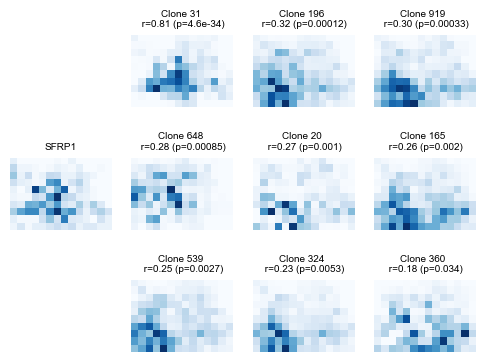

In [23]:
clusters,counts = np.unique(region['bc_cluster'],return_counts=True)

# get the clusters with at least 10 cells
clusters = clusters[counts>=10]
# drop na
clusters = clusters[~np.isnan(clusters)]

clusters = clusters[np.argsort(cluster_correlation)[::-1]]
correlations = np.sort(cluster_correlation)[::-1]

plt.figure(figsize=(4*1.5,3*1.5))
plt.subplot(3,4,5)
points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1']

bin_size = 514 # visium bin size
# bin_size = 74.77 # visiumHD bin size

n_x_bins = int((xmax-xmin)/bin_size)+1
n_y_bins = int((ymax-ymin)/bin_size)+1

H_gene, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(n_x_bins)],
                                                                   [ymin+bin_size*i for i in range(n_y_bins)]],
                                                                   range=[[xmin,xmin+bin_size*n_x_bins],[ymin,ymin+bin_size*n_x_bins]])

# Plot the 2D histogram
plt.imshow(H_gene.swapaxes(0,1), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Blues')
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
plt.gca().invert_yaxis()
plt.title('SFRP1')

# plt.gca().set_xticks(xedges)
# plt.gca().set_yticks(yedges)
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

# plt.xticks()
plt.axis('off')
# plt.show()

counter = 0

subplot_list = [2,3,4,6,7,8,10,11,12]

for c,cluster in enumerate(clusters):

    if correlations[c] < 0.15:
        continue
    
    c = counter

    this_name = region[region['bc_cluster']==cluster]['bc_cluster_bc_names'].values[0]
    cluster_barcodes = this_name.split('-')

    points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name'].isin(cluster_barcodes)]

    H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(int((xmax-xmin)/bin_size)+1)],
                                                                   [ymin+bin_size*i for i in range(int((ymax-ymin)/bin_size)+1)]],
                                                                   range=[[xmin,xmax],[ymin,ymax]])
    
    print(cluster)
    print(scipy.stats.pearsonr(H_gene.flatten(),H.flatten()))

    plt.subplot(3,4,subplot_list[c])

    # Plot the 2D histogram
    plt.imshow(H.swapaxes(0,1), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Blues')
    # plt.colorbar()
    # plt.gca().set_aspect('equal')
    # plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
    plt.gca().invert_yaxis()
    plt.title(f'Clone {int(cluster)} \n r={scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[0]:.2f} (p={scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[1]:.2g})')
    plt.axis('off')

    counter += 1

plt.savefig('../graphs/cluster_31_SFRP1_spots_visiumcomparision.pdf',bbox_inches='tight')
# plt.savefig('plots/figures/forpaper_cluster_31_SFRP1_spots_visiumHDcomparision.pdf',bbox_inches='tight')

In [24]:
confident_clusters_gdf.groupby(by='bc_cluster')['IFIT2'].mean().sort_values(ascending=False).head(10)

bc_cluster
756.0     0.593750
527.0     0.578947
722.0     0.500000
15.0      0.477157
490.0     0.454545
1303.0    0.322581
681.0     0.300000
266.0     0.291209
93.0      0.263158
72.0      0.261494
Name: IFIT2, dtype: float64

In [25]:
# confident_clusters_gdf.groupby(by='bc_cluster')['IFIT2']


confident_clusters_gdf[confident_clusters_gdf['IFIT2'] > 1].groupby(by='bc_cluster')['IFIT2'].count().sort_values(ascending=False).head(10)

bc_cluster
72.0      38
372.0     17
15.0       9
756.0      5
266.0      5
138.0      4
62.0       3
1303.0     3
2051.0     3
238.0      2
Name: IFIT2, dtype: int64

In [26]:
adata_genes.obs['bc_cluster']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
67197   NaN
67198   NaN
67199   NaN
67200   NaN
67201   NaN
Name: bc_cluster, Length: 67202, dtype: float64

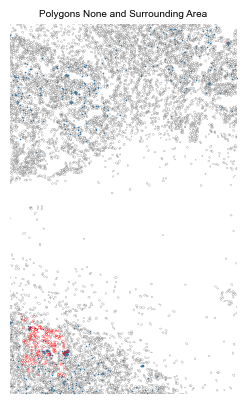

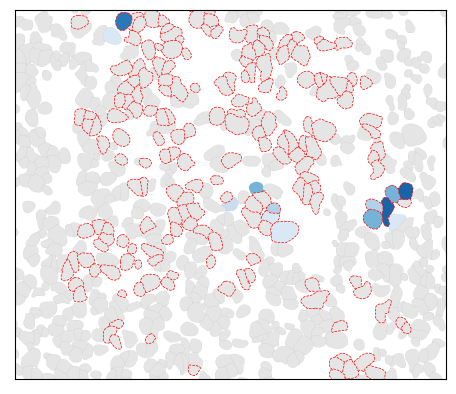

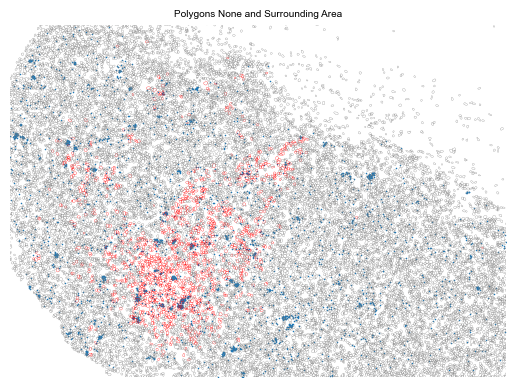

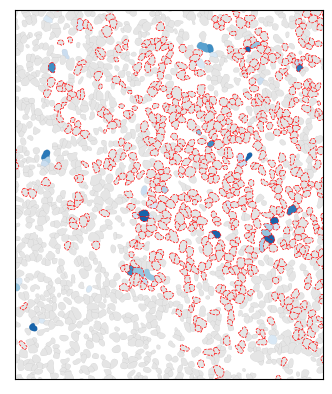

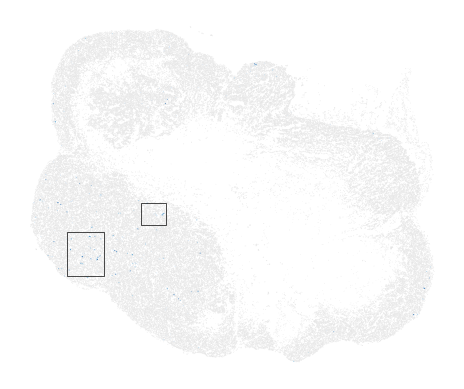

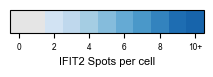

In [27]:
gene_of_interest = 'IFIT2'
clusters_of_interest = [15,72]
# clusters_of_interest = [72,372,15,756]

custom_lims = {15:[17000,20500,25000,28000],
               
               72:[7000,12000,29000,35000],}

cluster_boxes = {}

for cluster_of_interest in clusters_of_interest:

    # get the cells associated with the manual cluster
    cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster'].isin([cluster_of_interest])].obs['cell_id'].values)
    central_ix = int(len(cluster_cells)/2) 
    cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=-0.5,id_field='cell_id')

    fig,ax = plt.subplots()
    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=[gene_of_interest],central_polygon_ix=central_ix,
                                color_map={gene_of_interest:(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                                #    id_field='cell_id',
                                annotate=False,image_scale=0.1,
                                focal_outline_color='r',other_outline_color='gray',
                                interior_marker='.',single_mode=False,lw=0.2,
                                exterior_marker='.',marker_size=5,ax=ax)

    ymin,ymax = plt.ylim()
    xmin,xmax = plt.xlim()

    plt.axis('off')
    # plt.title()
    plt.gca().invert_yaxis()

    ### PLOT THE ZOOMED IN IMAGE     
    fig,ax = plt.subplots()

    vmin = 2
    vmax = 10

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    xmin = custom_lims[cluster_of_interest][0]
    xmax = custom_lims[cluster_of_interest][1]
    ymin = custom_lims[cluster_of_interest][2]
    ymax = custom_lims[cluster_of_interest][3]

    bbox = box(xmin,ymin,xmax,ymax)
    # bbox = box(custom_lims[cluster_of_interest][0],custom_lims[cluster_of_interest][2],custom_lims[cluster_of_interest][1],custom_lims[cluster_of_interest][3])
    other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

    merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

    cmap = matplotlib.cm.get_cmap('Blues').copy()
    cmap = cmap(np.linspace(0.15, 0.8, 256))

    cmap = matplotlib.colors.ListedColormap(cmap)
    cmap.set_under('#e5e5e5') # set low values to gray

    merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
    # this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

    merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

    # print(merged_gdf_focal.shape)
    merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

    # Add the patch to the Axes
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.gca().invert_yaxis()

    cluster_boxes[cluster_of_interest] = [xmin,xmax,ymin,ymax]

    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_facecolor('#F5F5F5')
    plt.savefig(f'../graphs/cluster_{cluster_of_interest}_{gene_of_interest}_zoom_grayed.pdf',bbox_inches='tight')


### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
fig,ax = plt.subplots()

merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.0)

rects = {}
for cluster,cluster_box in cluster_boxes.items():
    # rectangle where magnification is
    rects[cluster] = matplotlib.patches.Rectangle((cluster_box[0], cluster_box[2]), (cluster_box[1]-cluster_box[0]), 
                                        (cluster_box[3]-cluster_box[2]), linewidth=0.5, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rects[cluster])

ax.set_facecolor('#F5F5F5')
plt.axis('off')
plt.gca().invert_yaxis()

plt.savefig(f'../graphs/{gene_of_interest}_full_grayed.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/{gene_of_interest}_full_grayed.png',dpi=500,bbox_inches='tight',transparent=True)


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(2.5,0.3))
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='horizontal')
cb1.set_label(f'{gene_of_interest} Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])

plt.savefig(f'../graphs/{gene_of_interest}_colorbar_grayed.pdf',bbox_inches='tight',transparent=True)

